# Convolutional Autoencoder with K-Means for MNIST

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import time

# to import MNIST as torch tensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

## training and testing dataloaders

In [2]:
num_workers = 0
# how many samples per batch to load
batch_size = 100
lr = 1e-3
# how many epochs for training
num_epochs = 40

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## autoencoder neural network design

In [3]:
class cae(nn.Module):
    def __init__(self):
        super(cae, self).__init__()
        # convolutional encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # 16, 5, 5
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 32, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # 32, 2, 2
        )
        # autoencoder bottle neck
        self.latent = nn.Sequential(
            nn.Linear(32*2*2, 10),
            #nn.Sigmoid()
        )
        self.upscale = nn.Sequential(
            nn.Linear(10, 32*2*2),
            nn.ReLU(True),
        )
        # convolutional decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2),  # 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # 1, 28, 28
            nn.Sigmoid()
        )
    # forward learning path
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x.view(-1, 32*2*2))
        
        bottle_neck = x
        
        x = self.upscale(x)
        x = self.decoder(x.view(-1, 32, 2, 2))
        return x, bottle_neck

## CAE model instantiation

In [4]:
# build a CAE model
model = cae()
# set loss function
criterion = nn.MSELoss()
# choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=1e-7)
print(model)

cae(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (latent): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
  (upscale): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


## load wieghts

## training

In [ ]:
for x, y in iter(train_loader):
    images = x
grid = torchvision.utils.make_grid(images[-64:])
tb = SummaryWriter()
tb.add_image('images', grid)

x, y = (0, 0)

for epoch in range(num_epochs):
    train_total_loss = 0
    valid_total_loss = 0
    start_time = time.time()
    for batch_index, data in enumerate(train_loader):
        img, _ = data
        if (batch_index+1)%10 != 0:
            x += 1
            # forward path
            output, embed = model(img)
            loss = criterion(output, img)
            # back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_total_loss += loss.item()
            tb.add_scalar('training loss/step', loss.item(), x)
        else:
            y += 1
            with torch.no_grad():
                model.eval()
                output, _ = model(img)
                model.train()
                valid_total_loss += F.mse_loss(output, img).item()
            tb.add_scalar('validation loss/step', F.mse_loss(output, img).item(), y)
    
    # tensorboard stuff
    grid = torchvision.utils.make_grid(output[-64:])
    tb.add_image('images', grid)
    tb.add_histogram('test histo', embed, epoch)    
    tb.add_scalar('training loss', train_total_loss/(54000/batch_size), epoch)
    tb.add_scalar('validation loss', valid_total_loss/(6000/batch_size), epoch)
    end_time = time.time()
    
    # log
    print('epoch [{}/{}], training loss:{:.4f}, validation loss:{:.4f}, expected runtime:{:.4f} min'
          .format(epoch+1, num_epochs, train_total_loss/(54000/batch_size), valid_total_loss/(6000/batch_size),
                  (end_time - start_time)*num_epochs/60))

## visualizing reconstructed results
### NOTE TO SELF: to be automated through DV

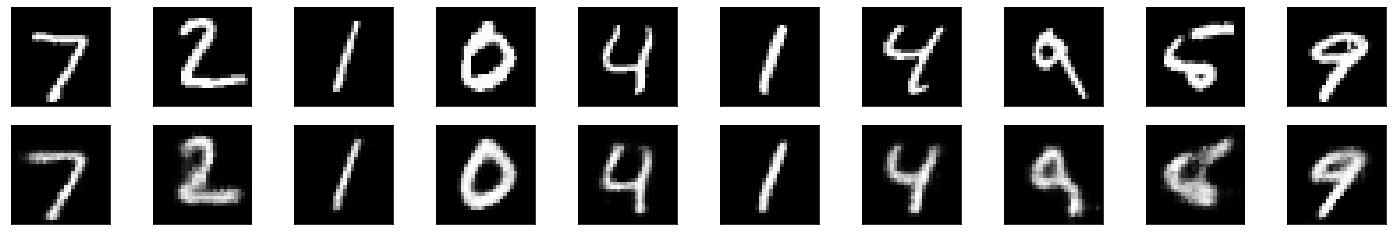

In [9]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter.next()
model.eval()

# get sample outputs
with torch.no_grad():
    output, _ = model(images)
# prep images for display
images = images.numpy()# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## reconstruct the train dataset

In [10]:
# run the dataset through the trained model
model.eval()
for image_index, data in enumerate(train_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    decoded, encoded = model(images)
    if not image_index:
        #First group encoded in new array
        embedded = encoded.detach().numpy()
        #first group decoded
        disembedded = decoded.detach().numpy()
        #labels
        labels = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded = np.vstack((embedded, encoded.detach().numpy()))
    disembedded = np.vstack((disembedded, decoded.detach().numpy()))
    labels = np.hstack((labels, itr_labels.detach().numpy()))

## clustering model instantiation and training

In [11]:
from sklearn.cluster import KMeans

# create a k-means model to cluster the embedded features
clustering_model = KMeans(n_clusters=10, tol = 1e-4, max_iter = 400).fit(embedded)

## visualizing results and performance evaluation

### testing autoencoder

In [12]:
# run the dataset through the trained model
model.eval()
for image_index, data in enumerate(test_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    decoded, encoded = model(images)
    if not image_index:
        #First group encoded in new array
        embedded_test = encoded.detach().numpy()
        #first group decoded
        disembedded_test = decoded.detach().numpy()
        #labels
        labels_test = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded_test = np.vstack((embedded_test, encoded.detach().numpy()))
    disembedded_test = np.vstack((disembedded_test, decoded.detach().numpy()))
    labels_test = np.hstack((labels_test, itr_labels.detach().numpy()))

In [13]:
labels_pred = clustering_model.predict(embedded_test)

In [14]:
import import_ipynb
import DataVisuals as dv


view_results = dv.DataVisuals(disembedded.reshape(-1, 28,28), labels, clustering_model.labels_)
view_results_test = dv.DataVisuals(disembedded_test.reshape(-1, 28,28), labels_test, labels_pred)

importing Jupyter notebook from DataVisuals.ipynb


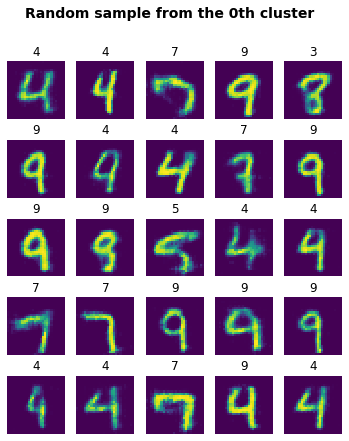

In [15]:
#view reconstructed random samples belonging to the same cluster
view_results.view_lblsample(0)

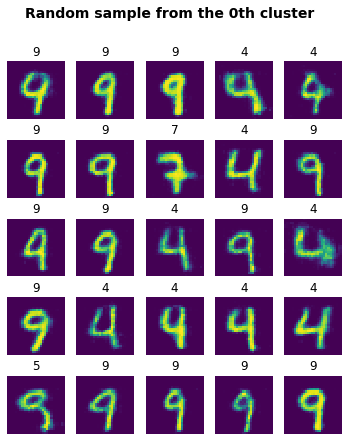

In [16]:
# test data
view_results_test.view_lblsample(0)

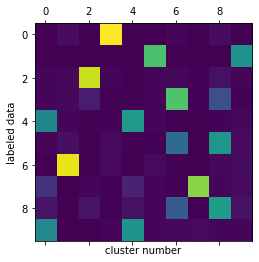

In [17]:
view_results.cm()

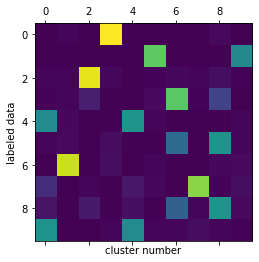

In [18]:
view_results_test.cm()

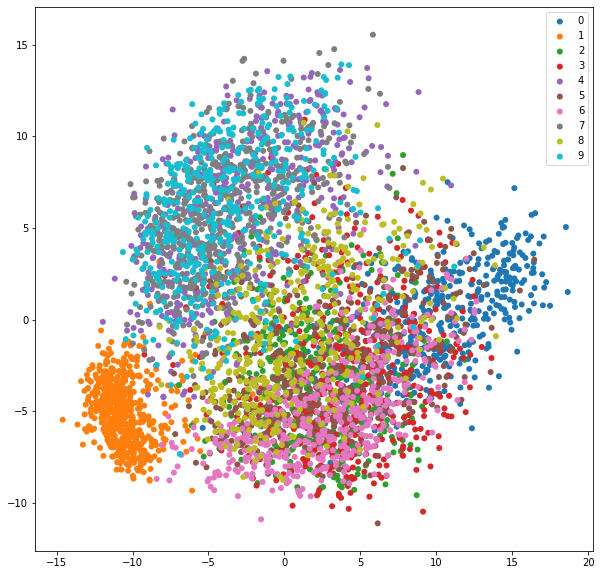

In [19]:
view_results.scat(embedded)

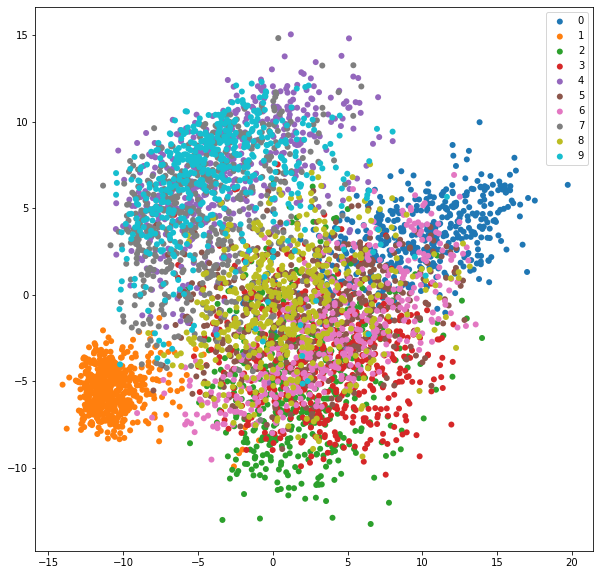

In [20]:
view_results_test.scat(embedded_test)

In [21]:
metric = dv.Metrics(labels, clustering_model.labels_)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.5898 
ARI = 0.4821 
ACC = 0.6109


In [22]:
metric = dv.Metrics(labels_test, labels_pred)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.6111 
ARI = 0.5008 
ACC = 0.6256


## store wieghts